In [ ]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

In [62]:
def load_model():
    model = MobileNetV2(weights='imagenet')
    return model

model = load_model()

In [63]:
def create_adversarial_pattern(input_image, input_label):
    input_image = tf.convert_to_tensor(input_image)
    input_label = tf.convert_to_tensor(input_label)

    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = tf.keras.losses.CategoricalCrossentropy()(input_label, prediction)
    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    return signed_grad

In [64]:
img_path = 'elephant.jpg'
orig = image.load_img(img_path, target_size=(224, 224))
x_orig = image.img_to_array(orig)
x = np.expand_dims(x_orig, axis=0)

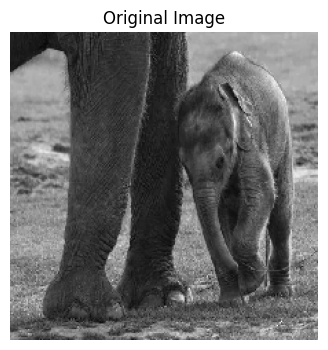

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Original Top-3 Predictions: [('n02504013', 'Indian_elephant', np.float32(0.7596931)), ('n02504458', 'African_elephant', np.float32(0.16063641)), ('n01871265', 'tusker', np.float32(0.05093186))]


In [65]:
x = preprocess_input(x)
plt.figure(figsize=(4,4))
plt.imshow(orig)
plt.title('Original Image')
plt.axis('off')
plt.show()
orig_preds = model.predict(x)
print("Original Top-3 Predictions:", decode_predictions(orig_preds, top=3)[0])

In [66]:

top_class = np.argmax(orig_preds[0])
label = tf.one_hot([top_class], orig_preds.shape[-1])

In [67]:
epsilon = 0.01  # strength of FGSM perturbation
perturbations = create_adversarial_pattern(x, label)
adv_x = tf.clip_by_value(x + epsilon * perturbations, -1.0, 1.0)
adv_preds = model.predict(adv_x)
print("FGSM (epsilon={}) Top-3 Predictions:".format(epsilon), decode_predictions(adv_preds, top=3)[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
FGSM (epsilon=0.01) Top-3 Predictions: [('n02504458', 'African_elephant', np.float32(0.92235273)), ('n01871265', 'tusker', np.float32(0.025390243)), ('n02504013', 'Indian_elephant', np.float32(0.0017609529))]


In [68]:
gamma = 0.01  # standard deviation of Gaussian noise
gauss_noise = tf.random.normal(shape=x.shape, mean=0.0, stddev=gamma)
gauss_x = tf.clip_by_value(x + gauss_noise, -1.0, 1.0)
gauss_preds = model.predict(gauss_x)
print("Gaussian Noise (sigma={}) Top-3 Predictions:".format(gamma), decode_predictions(gauss_preds, top=3)[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Gaussian Noise (sigma=0.01) Top-3 Predictions: [('n02504013', 'Indian_elephant', np.float32(0.6895271)), ('n02504458', 'African_elephant', np.float32(0.2198357)), ('n01871265', 'tusker', np.float32(0.053841803))]


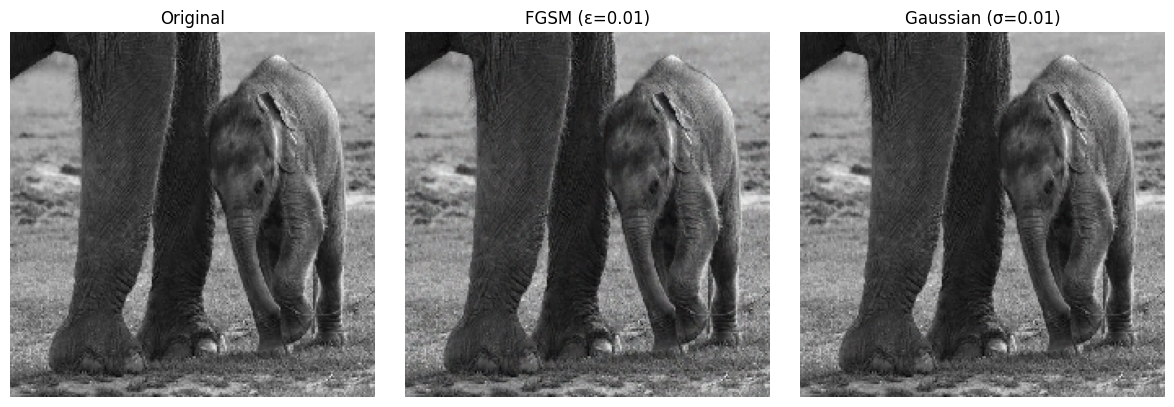

In [69]:
plt.figure(figsize=(12,4))
for i, (img_tensor, title) in enumerate([
    (x, 'Original'),
    (adv_x, f'FGSM (ε={epsilon})'),
    (gauss_x, f'Gaussian (σ={gamma})'),
]):
    plt.subplot(1, 3, i+1)
    # De-process input back to [0,1] for display
    disp = (img_tensor[0] + 1.0) / 2.0
    plt.imshow(disp)
    plt.title(title)
    plt.axis('off')
plt.tight_layout()
plt.show()